In [28]:
%matplotlib inline
from IPython.display import display, Latex, Markdown
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import lsqr
from scipy.ndimage import gaussian_filter
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
RANDOMSEED = 125843

# 1. Denoising a  CT image

In [15]:
def construct_X(M, angles, Np=None, tau=0):
    """
    Construct weight matrix for image dimensions MxM,
    angles: Array of sensor angles
    Np: number of sensors
    
    Indice names:
    i_p : sensor index
    i_o : angle/orientation index
    i = i_p + Np * i_o  : response index
    a, b : image coordinates
    j = a + M * b   : flattened image coordinates
    """
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
        Np = Np if Np % 2 else Np + 1
#         print(f"Np = {Np}")
    # index boundaries
    D = M**2
    No = len(angles)
    N = No * Np
    
    # coordinate matrix: coordinates of all pixel centers
    # as column vectors
    C = np.mgrid[M-1:-1:-1, :M:1].astype(np.float64).reshape(2, -1)
    center = M / 2
    C += 0.5 - center
        
    # convert angles from degrees to radians
    angles = np.unwrap(np.deg2rad(angles))
    
    # matrix of normal vectors for sensor positions
    n = np.column_stack([np.sin(angles), np.cos(angles)])
    
    # position of sensor 0 to sensor coordinate system
    s0 = Np / 2 - 0.5
    
    # projections of pixel onto sensor
    # first dim: angles, 2. dim: j
    p = np.dot(n, C) + s0

    # floor as left sensor index, fraction as weight for right sensor
    i_ind1, weight2 = np.divmod(p, 1)
    # weight for left sensor, indices for right sensor
    weight1 = 1 - weight2
    i_ind2 = i_ind1 + 1
    # filter all sensor out of range
    mask1 = np.logical_and(i_ind1 >= 0, i_ind1 < Np)
    mask2 = np.logical_and(i_ind2 >= 0, i_ind2 < Np)
    # transform i_ind from i_p to i = i_p + Np * i_o
    for i_o in range(No):
        i_ind1[i_o] += i_o * Np
        i_ind2[i_o] += i_o * Np
    # generate j_indices from mask
    j_ind1 = np.nonzero(mask1.flatten())[0] % D
    j_ind2 = np.nonzero(mask2.flatten())[0] % D
    # concatenate & flatten all indices and weights
    weights = np.concatenate((weight1[mask1].flatten(), weight2[mask2].flatten()))
    i_ind = np.concatenate((i_ind1[mask1].flatten(), i_ind2[mask2].flatten()))
    j_ind = np.concatenate((j_ind1, j_ind2))
    
    # construct sparse matrix convert to csc-matrix for solving
    X = sp.coo_matrix((weights, (i_ind, j_ind)), shape=(N, D), dtype=np.float32)
    if tau == 0:
        return X
    else:
        tau_mat = np.sqrt(tau) * sp.identity(D)
        return sp.vstack((X, tau_mat), format='csc')

In [16]:
def image(alphas, response, M, Np, tau=0, tol=1e-4, verbose=True):
    "Recover image and measure time"
    if verbose:
        print(f"Recovering image with M={M}, Np={Np}, No={len(alphas)}, Regularization tau={tau}, tolerance={tol}")
    t0 = time.time()
    # construct weight matrix
    X = construct_X(M, alphas, Np, tau)
    t1 = time.time()
    if verbose:
        print(f"Sparsity of X: { 1 - X.nnz / np.product(X.shape)}, Time to construct X: {t1-t0:.2f}s")
    # extend response vector if necesary
    if tau != 0:
        response = np.copy(response)
        response.resize(X.shape[0])
    # find least squares solution
    beta = lsqr(X, response, atol=tol, btol=tol)[0]
    t2 = time.time()
    if verbose:
        print(f"Solved for image in {t2-t1:.2f}s with tolerance {tol}, total time {t2-t0:.2f}s")
    return beta.reshape(M,M)

In [17]:
alphas = np.load('hs_tomography/alphas_195.npy')
response = np.load('hs_tomography/y_195.npy')

### CT denoising with regularization

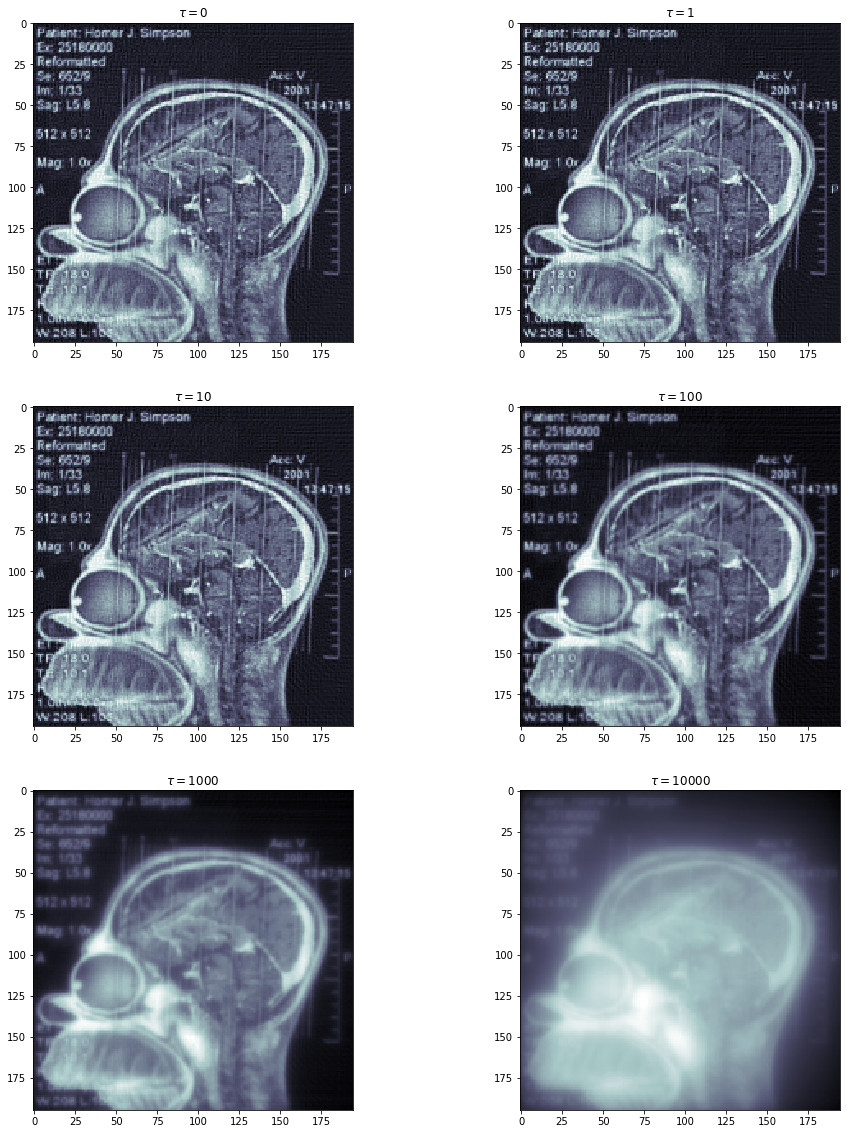

In [27]:
fig, axes = plt.subplots(3,2, figsize=(16,20))
tau = [0, 1, 10, 100, 1000, 10000]
display(Markdown("### CT denoising with regularization"))
for t, ax in zip(tau, axes.flat):
    beta = image(alphas, response, tol=1e-4, M=195, Np=275, tau=t, verbose=False)
    ax.set_title(r"$\tau = {}$".format(t))
    ax.imshow(beta, cmap='bone');

We can see that even with high regularization parameters, the image is smoother, but we can see most of the features without most noise.
The best tradeoff between features and smoothness in the picture with $\tau = 1000$

In [19]:
beta_orig = image(alphas, response, tol=1e-4, M=195, Np=275, tau=0)

Recovering image with M=195, Np=275, No=179, Regularization tau=0, tolerance=0.0001
Sparsity of X: 0.9927272834122856, Time to construct X: 0.89s
Solved for image in 3.43s with tolerance 0.0001, total time 4.32s


### CT denoising with gaussian filter

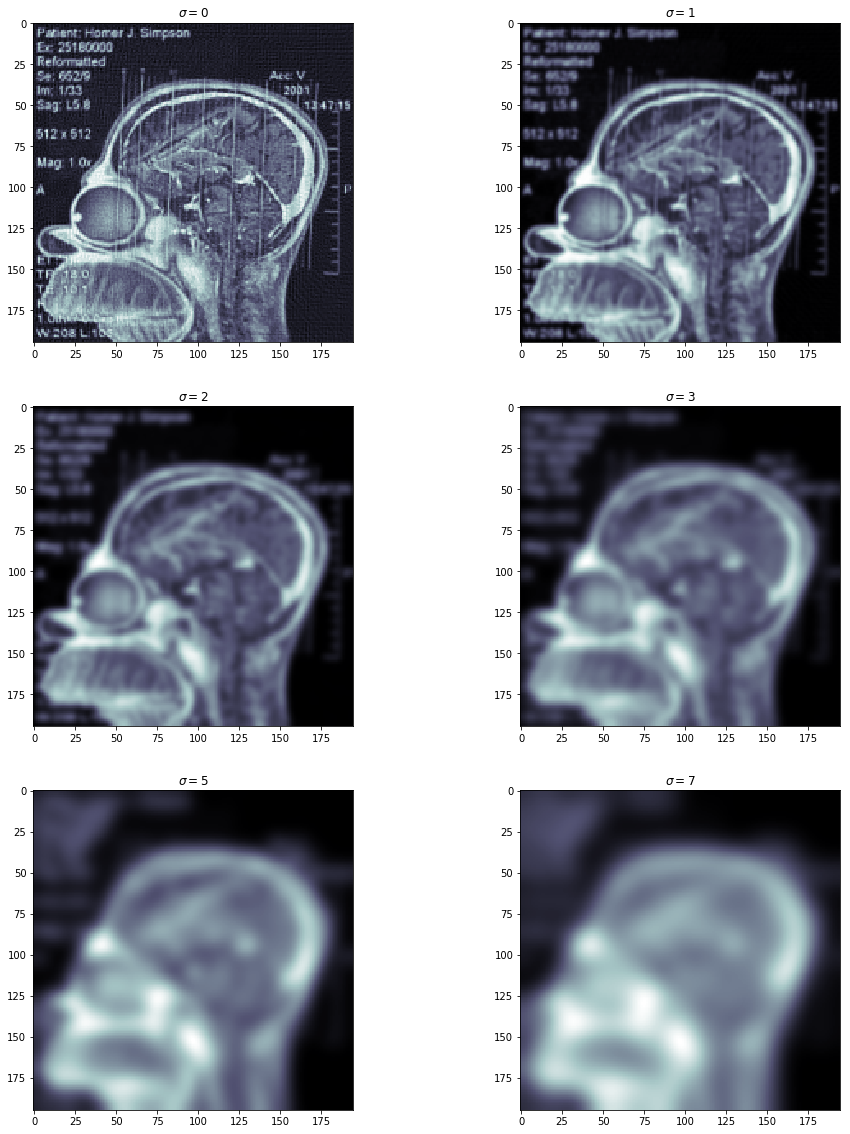

In [29]:
fig, axes = plt.subplots(3, 2, figsize=(16,20))
sigma = [0,1,2,3,5,7]
display(Markdown("### CT denoising with gaussian filter"))
for s, ax in zip(sigma, axes.flat):
    ax.set_title(r"$\sigma = {}$".format(s))
    ax.imshow(gaussian_filter(beta_orig, sigma=s), cmap='bone');

As we can see here, gaussian filtering is smoother for the human eye, but we can see less detail in a similar smooth image. So gaussian filtering is suited for nice pictures, but regularization for scientific uses.

# 3. Automatic feature selection

## 3.1 Orthogonal matching pursuit

In [131]:
def omp_regression(X, y, T):
    """
    Inputs:
    X : NxD matrix
    y : N vector
    T > 0, integer
    """
    # initialization
    # active & inactive columns
    active = np.zeros(shape=(X.shape[1]), dtype=bool)
    # initial residual
    r = np.copy(y)      
    
    beta = np.zeros((X.shape[1], T))
    
    for i in range(T):
        corr = abs(np.dot(X.T, r))
        corr[active] = np.nan
        j = np.nanargmax(corr)
        active[j] = True

        beta[active,i] = lsqr(X[:,active], y)[0]

        r = y - np.dot(X[:,active], beta[active,i])
    
    return beta

## 3.2 Classification with Sparse LDA

In [147]:
digits = load_digits()
mask = (digits.target == 1) | (digits.target == 7)
x_data = digits.data[mask]/digits.data.max()
labels = digits.target[mask]
response = np.ones_like(y_labels)
response[y_labels == 7] = -1

In [148]:
# split into training/test set, fit and predict
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    response,
                                                    test_size=0.4,
                                                    random_state=RANDOMSEED)

In [161]:
beta = omp_regression(x_train, y_train, 60)

In [177]:
predicted = np.dot(x_test, beta)
mask = predicted >= 0
predicted[mask] = 1
predicted[~mask] = 7
right_answers = np.equal(predicted.T, y_test)
np.count_nonzero(right_answers, axis=1)

array([68, 58, 59, 61, 64, 61, 60, 60, 58, 60, 60, 61, 63, 62, 62, 63, 61,
       60, 60, 58, 59, 58, 59, 59, 60, 60, 59, 59, 59, 59, 59, 59, 59, 59,
       59, 57, 57, 59, 59, 59, 59, 59, 59, 59, 59, 58, 58, 58, 58, 58, 58,
       58, 58, 58, 58, 58, 58, 58, 58, 58])

In [175]:
np.equal(predicted.T, y_test)

array([[ True, False,  True, ..., False, False,  True],
       [False, False,  True, ..., False, False,  True],
       [False, False,  True, ..., False, False,  True],
       ..., 
       [ True, False,  True, ..., False, False,  True],
       [ True, False,  True, ..., False, False,  True],
       [ True, False,  True, ..., False, False,  True]], dtype=bool)

In [169]:
y_test

array([1, 7, 1, 7, 7, 7, 7, 1, 7, 7, 7, 1, 7, 1, 1, 1, 1, 1, 1, 7, 7, 7, 1,
       1, 7, 7, 1, 1, 7, 1, 1, 7, 7, 1, 7, 7, 7, 1, 1, 7, 7, 1, 7, 7, 7, 7,
       1, 1, 1, 1, 7, 1, 1, 7, 7, 1, 1, 1, 1, 7, 7, 7, 7, 7, 7, 7, 1, 1, 1,
       7, 7, 7, 1, 1, 1, 7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 1, 1, 7, 7, 1, 7, 1,
       7, 7, 7, 1, 7, 1, 1, 1, 7, 1, 1, 7, 7, 7, 7, 1, 7, 1, 1, 1, 1, 1, 1,
       1, 1, 7, 1, 1, 1, 7, 1, 1, 7, 7, 1, 7, 7, 7, 1, 7, 7, 7, 7, 7, 1, 1,
       1, 1, 7, 7, 7, 7, 1])

## 3.3 One-against-the-rest classification

In [198]:
mask7 = digits.target == 7
N = digits.data.shape[0] - np.count_nonzero(mask7)
other_ind = np.random.choice(N, np.count_nonzero(mask7))
x_data = np.concatenate((digits.data[mask7], digits.data[~mask7][other_ind]))
y_label = np.concatenate((digits.target[mask7], digits.target[~mask7][other_ind]))

In [192]:
digits.data[~mask7][other_ind]

array([[  0.,   0.,   0.,   2.,  13.,  13.,   0.,   0.,   0.,   0.,   0.,
         12.,  10.,  16.,   0.,   0.,   0.,   0.,   7.,  13.,   8.,  11.,
          0.,   0.,   0.,   0.,   5.,  16.,  16.,   4.,   0.,   0.,   0.,
          0.,   3.,  16.,  16.,   4.,   0.,   0.,   0.,   2.,  14.,   9.,
          7.,  13.,   1.,   0.,   0.,   1.,  11.,   8.,   3.,   9.,   8.,
          0.,   0.,   0.,   0.,   5.,  10.,  15.,  16.,   0.],
       [  0.,   0.,   5.,  15.,   9.,   0.,   0.,   0.,   0.,   0.,  15.,
          6.,  11.,   6.,   0.,   0.,   0.,   7.,   9.,   0.,   0.,  14.,
          0.,   0.,   0.,   5.,   9.,   0.,   0.,   8.,   6.,   0.,   0.,
          4.,  13.,   0.,   0.,   4.,   8.,   0.,   0.,   1.,  16.,   0.,
          0.,   4.,  11.,   0.,   0.,   0.,  15.,   7.,   5.,  16.,   4.,
          0.,   0.,   0.,   2.,  15.,  15.,   5.,   0.,   0.],
       [  0.,   0.,   7.,  15.,  15.,   4.,   0.,   0.,   0.,   8.,  16.,
         16.,  16.,   4.,   0.,   0.,   0.,   8.,  15.,   8.